(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
@load_pkg ActiveInference
# Import package to revise jlArchetype modules
using Revise

# Import project package
import ActiveInference as AI

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# A tutorial on the free-energy framework for modelling perception and learning

This notebook accompanies a series of notes based on the [2017 paper by
Bogacz](https://www.sciencedirect.com/science/article/pii/S0022249615000759).

## Simplest example of perception

Let us imagine an organism that is trying to determine the radius of an object
$r$ based on the light intensity. We assume the organism has a receptor that
gives a noisy readout of the **log** light intensity $I$. Let us then define
$$
g(r) = \ln r^2 = 2 \ln r,
\tag{1}
$$
be the non-linear function that relates the size of the object to the
log-intensity.

**Note**: *In the paper, the author uses only $g(r) = r^2$, but acknowledges that
then using a Gaussian distribution is problematic as it can take negative
values. Thus, I added the log to transform the variable.*


Let us then assume that for an object of size $r$, the organism's noisy receptor
gives a noisy readout of the form
$$
I \mid r \sim \mathcal{N}\left(g(r), \Sigma^{(I)}_l \right).
\tag{2}
$$
Given this level of noise, the organism uses prior knowledge---acquired by 
experience to encode its expectations on the size of the objects it perceives 
with this particular receptor. This prior is of the form
$$
r \sim \mathcal{N}\left(\mu^{(r)}_p, \Sigma^{(r)}_p \right),
\tag{3}
$$
where the subscript $p$ represents "prior" information. Given a measurement, the
organism estimates the size of the object by computing Bayes' theorem
$$
\pi(r \mid I) = \frac{\pi(I \mid r) \pi(r)}{\pi(I)},
\tag{4}
$$
where the technical problem comes from computing the denominator
$$
\pi(I) = \int dr\; \pi(I \mid r) \pi(r).
\tag{5}
$$

Let us now assume that the organism gets to read out from its receptor a single
measurement:
- $I = 2$.
Furthermore, we assume the following parameters for the mean and variances:
- $\Sigma^{(I)}_l = 1$,
- $\mu^{(r)}_p = 3$,
- $\Sigma^{(r)}_p = 1$.

To be able to compute Eq. 4, we first need a way to compute the integral in
Eq. 5. Let us define a function to compute this integral via a simple numerical
quadrature. 

In [2]:
@doc raw"""
    quad_midpoint(f, a, b, N)

Numerically integrates function `f` from `a` to `b` with `N` points.

# Arguments
- `f::function`: 1D-real-valued function to be integrated.
- `a::Real`: Integration lower limit.
- `b::Real`: Integration upper limit.
- `N::Int`: Number of steps to take
"""
function quad_midpoint(f::Function, a::Real, b::Real, N::Int)
    # Define width of each bin
    h = (b - a) / N

    # Initialize value of integral
    int = 0.0

    # Loop through steps
    for k = 1:N
        # Define mid point for k-th iteration
        xₖ_mid = (b - a) * (2k - 1) / (2N) + a
        # Add value of bin to integral.
        int += h * f(xₖ_mid)
    end # for

    return int
end # function

quad_midpoint

Next, let us define a function to evaluate the posterior distribution we want
to evaluate.

In [64]:
@doc raw"""
 π_r_I

Function to compute the posterior distribution π(r | I).

# Arguments
- `I::Real`: Value of the (log) intensity read by the detector.
- `r::Vector{<:Real}`: Object radius over which to evaluate the posterior dist.
- `Σᵣ::Real`: Value of the likelihood variance.
- `μₚ⁽ʳ⁾::Real`: Mean of the prior distribution of object radius size.
- `Σₚ⁽ʳ⁾::Real`: Variance of the prior distribution of object radius size.

## Optional Keyword Arguments
- `g::Function`: Non-linear function mapping form radius to detector readout.
- `N::Int`: Number of bins used to perform the integration for the evidence.
  Default = 1000.

# Returns
- `π(r|I)::Array{Float64}`: Array evaluating the posterior distribution at all
  values of `r`.
"""
function π_r_I(
    I::Real,
    r::Vector{<:Real},
    Σₗ⁽ᴵ⁾::Real,
    μₚ⁽ʳ⁾::Real,
    Σₚ⁽ʳ⁾::Real;
    g::Function=x -> log(x^2),
    N::Int=1000
)
    # Define prior distribution
    π_prior(x) = Distributions.pdf(Distributions.Normal(μₚ⁽ʳ⁾, √(Σₚ⁽ʳ⁾)), x)
    # Define likelihood distribution
    π_likelihood(x) = Distributions.pdf(Distributions.Normal(g(x), √(Σₗ⁽ᴵ⁾)), I)
    # Compute the evidence performing numerical integration
    π_evidence = quad_midpoint(
        y -> π_likelihood(y) * π_prior(y),
        r[1],
        r[end],
        N
    )
    # Evaluate posterior for each value of r
    return [π_prior(x) * π_likelihood(x) / π_evidence for x in r]
end # function

π_r_I

Having defined the function, let's look at the posterior distribution.

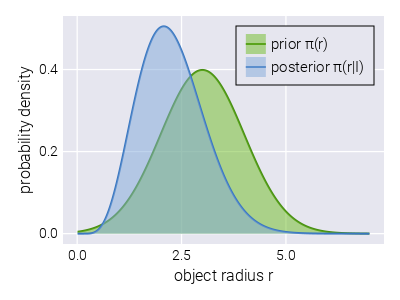

In [74]:
# Define ranges of r to evaluate
r = collect(LinRange(0.01, 7, 1000))

# Define parameters
I = 0.5
Σₗ⁽ᴵ⁾ = 1
μₚ⁽ʳ⁾ = 3
Σₚ⁽ʳ⁾ = 1

# Evaluate prior
π_prior = Distributions.pdf.(Ref(Distributions.Normal(μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾)), r)
# Evaluate posterior
π_posterior = π_r_I(I, r, Σₗ⁽ᴵ⁾, μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾; g=x -> log(x^2))

# Extract colors
color_palette = AI.viz.colors()

# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="object radius r",
    ylabel="probability density"
)

# Plot prior distribution
lines!(
    ax,
    r,
    π_prior,
    label="prior π(r)",
    color=color_palette[:green]
)
fill_between!(
    ax,
    r,
    zeros(length(r)),
    π_prior,
    label="prior π(r)",
    color=(color_palette[:light_green], 0.5)
)

# Plot posterior distribution
lines!(
    ax,
    r,
    π_posterior,
    label="posterior π(r|I)",
    color=color_palette[:blue]
)

fill_between!(
    ax,
    r,
    zeros(length(r)),
    π_posterior,
    label="posterior π(r|I)",
    color=(color_palette[:light_blue], 0.5)
)

# Add legend
axislegend(ax, unique=true, merge=true)

fig

## Finding the most-likely feature value

The previous result is difficult to compute with neuronal or molecular
components. An alternative perspective is to compute the so-called MAP that
maximizes the posterior distribution $\pi(r \mid I)$. Therefore, our goal 
becomes to compute
$$
r^* = \max_r \pi(r \mid I) \pi(r),
\tag{6}
$$
where we ignore the denominator of Eq. 4 since it does not depend on the value 
of $r$. Maximizing this product is equivalent to maximizing the negative of the
free energy that we define as
$$
F \equiv \ln \pi(r \mid I) + \ln \pi(r).
\tag{7}
$$

To compute this maximum, we must compute the derivative of $F$ with respect to
$r$, obtaining
$$
\frac{dF}{dr} = \frac{I - g(r)}{\Sigma_l^{(I)}} \frac{dg}{dr} +
\frac{r - \mu^{(r)}_p}{\Sigma^{(r)}_p}.
\tag{8}
$$
Although solving for $r$ becomes challenging due to the non-linearity of $g$, we
can arrive at a value for $r^*$ by iteratively updating the value of $r$ over
time using Euler's integration method. This is
$$
r(t + \Delta t) = r(t) + \frac{dF}{dr}\Delta t.
\tag{9}
$$

Let's implement a function that computes this update. Note that for this 
function we will require a closed-form solution for $dg/dr$. We could make this
more general by using an automatic differentiation tool.

In [47]:
@doc raw"""
    r_opt_euler

Function to compute the MAP, i.e., the value of r that maximizes the posterior
π(r | I) using Euler's integration method.

# Arguments
- `rₒ::Real`: Initial estimate of the object dimensions.
- `I::Real`: Value of the (log) intensity read by the detector.
- `Σᵣ::Real`: Value of the likelihood variance.
- `μₚ⁽ʳ⁾::Real`: Mean of the prior distribution of object radius size.
- `Σₚ⁽ʳ⁾::Real`: Variance of the prior distribution of object radius size.

## Optional Keyword Arguments
- `g::Function`: Non-linear function mapping form radius to detector readout.
- `dg::Function`: Non-linear derivative of function mapping form radius to
  detector readout.
- `n_steps::Int`: Number of steps over which to perform integration. Default =
  1000.
- `Δt::AbstractFloat`: Step-size for the integration. Default = 0.01

# Returns
- `r::Array{Float64}`: Array with the trajectory of the estimated MAP.
- `time::Array{Float64}`: Array with the times where the integration was
  evaluated.
"""
function r_opt_euler(
    rₒ::Real,
    I::Real,
    Σₗ⁽ᴵ⁾::Real,
    μₚ⁽ʳ⁾::Real,
    Σₚ⁽ʳ⁾::Real;
    g::Function=x -> log(x^2),
    dg::Function=x -> 2 / x,
    n_steps::Int=1_000,
    Δt::AbstractFloat=0.01
)
    # Initialize array to save values of r
    r = Array{Float64}(undef, n_steps + 1)
    # Initialize array to save the time
    time = similar(r)

    # Set initial value
    r[1] = Float64(rₒ)
    time[1] = 0.0

    # Loop through iterations
    for t = 2:(n_steps+1)
        # Compute dF/dr
        dF_dr = (I - g(r[t-1])) / Σₗ⁽ᴵ⁾ * dg(r[t-1]) -
                (r[t-1] - μₚ⁽ʳ⁾) / Σₚ⁽ʳ⁾

        # Update value of r
        r[t] = r[t-1] + Δt * dF_dr
        # Update value of time
        time[t] = time[t-1] + Δt
    end # for

    return r, time
end # function

r_opt_euler

Let us now compute the value of $r$ over time.

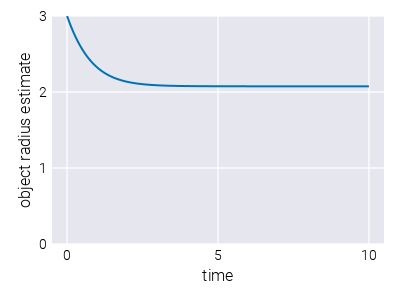

In [76]:
# Define parameters
rₒ = 3
I = 0.5
Σₗ⁽ᴵ⁾ = 1
μₚ⁽ʳ⁾ = 3
Σₚ⁽ʳ⁾ = 1

# Evaluate trajectory
r_opt, time = r_opt_euler(
    rₒ, I, Σₗ⁽ᴵ⁾, μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾; n_steps=1_000, g=x -> log(x^2), dg=x -> 2 / x
)
# r_opt, time = r_opt_euler(
#     rₒ, I, Σₗ⁽ᴵ⁾, μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾; n_steps=1_000, g=x -> x^2, dg=x -> 2x
# )

# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time",
    ylabel="object radius estimate"
)

# Plot trajectory
lines!(ax, time, r_opt)

ylims!(ax, [0, 3])

fig

Let's compare the final value with the value of the full posterior distribution.

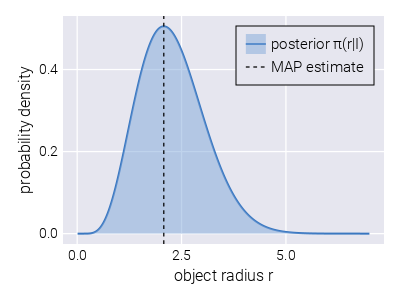

In [77]:
# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="object radius r",
    ylabel="probability density"
)

# Plot posterior distribution
lines!(
    ax,
    r,
    π_posterior,
    label="posterior π(r|I)",
    color=color_palette[:blue]
)

fill_between!(
    ax,
    r,
    zeros(length(r)),
    π_posterior,
    label="posterior π(r|I)",
    color=(color_palette[:light_blue], 0.5)
)

# Add final value
vlines!(
    r_opt[end],
    linestyle=:dash,
    color=:black,
    label="MAP estimate"
)

# Add legend
axislegend(ax, unique=true, merge=true)

fig